In [108]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [109]:
def cartoonify_image(image_path):
    # Read the image
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Apply median blur for noise reduction
    gray_blur = cv2.medianBlur(gray, 7)
    
    # Apply Laplacian filter for edge detection
    edges = cv2.Laplacian(gray_blur, cv2.CV_8U, ksize=5)
    edges_thresh = cv2.threshold(edges, 30, 255, cv2.THRESH_BINARY)[1]
    img_small = cv2.resize(img, (img.shape[1] // 2, img.shape[0] // 2))
    for _ in range(30):
        img_small = cv2.bilateralFilter(img_small, 9, 100, 300)
    color = cv2.resize(img_small, (img.shape[1], img.shape[0]))
    
    
    # Combine edges with the color image
    edges_inv = cv2.bitwise_not(edges_thresh)
    #cartoon = cv2.addWeighted(color, 0.8, cv2.cvtColor(edges_inv, cv2.COLOR_GRAY2RGB), 0.2, 0)
    cartoon = cv2.bitwise_and(color, color, mask=edges_inv)
    
    # Show results
    plt.figure(figsize=(20, 10)),plt.subplot(2, 3, 1),plt.imshow(img),plt.title("Original Image"),plt.axis("off")

    plt.subplot(2, 3, 2),plt.imshow(gray, cmap="gray"),plt.title("Grayscale Image"),plt.axis("off")

    plt.subplot(2, 3, 3),plt.imshow(gray_blur, cmap="gray"),plt.title("After Median Blur"),plt.axis("off")

    plt.subplot(2, 3, 4),plt.imshow(edges, cmap="gray"),plt.title("Edge Detection (Laplacian)"),plt.axis("off")

    plt.subplot(2, 3, 5),plt.imshow(edges_inv, cmap="gray"),plt.title("Edge Detection (Thresholded)"),plt.axis("off")

    plt.subplot(2, 3, 6),plt.imshow(cartoon),plt.title("Cartoon Effect"),plt.axis("off")

    plt.show()

In [110]:
def detect_lanes(image_path):
    # Read the image
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Apply Gaussian Blur
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    
    # Edge detection using Canny
    edges = cv2.Canny(blurred, 50, 150)
    
    # Define Region of Interest (ROI)
    height, width = edges.shape
    mask = np.zeros_like(edges)
    polygon = np.array([[(50, height), (width-50, height), (width//2, height//2)]], np.int32)
    cv2.fillPoly(mask, polygon, 255)
    roi_edges = cv2.bitwise_and(edges, mask)
    
    # Detect lanes using Hough Transform
    lines = cv2.HoughLinesP(roi_edges, 1, np.pi/180, 50, minLineLength=100, maxLineGap=50)
    result = img.copy()
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            cv2.line(result, (x1, y1), (x2, y2), (255, 0, 0), 3)
    
    # Show results
    plt.figure(figsize=(10,5))
    plt.subplot(1,3,1), plt.imshow(img), plt.title("Original Image"), plt.axis("off")
    plt.subplot(1,3,2), plt.imshow(edges, cmap='gray'), plt.title("Edge Detection"), plt.axis("off")
    plt.subplot(1,3,3), plt.imshow(result), plt.title("Lane Detection"), plt.axis("off")
    plt.show()

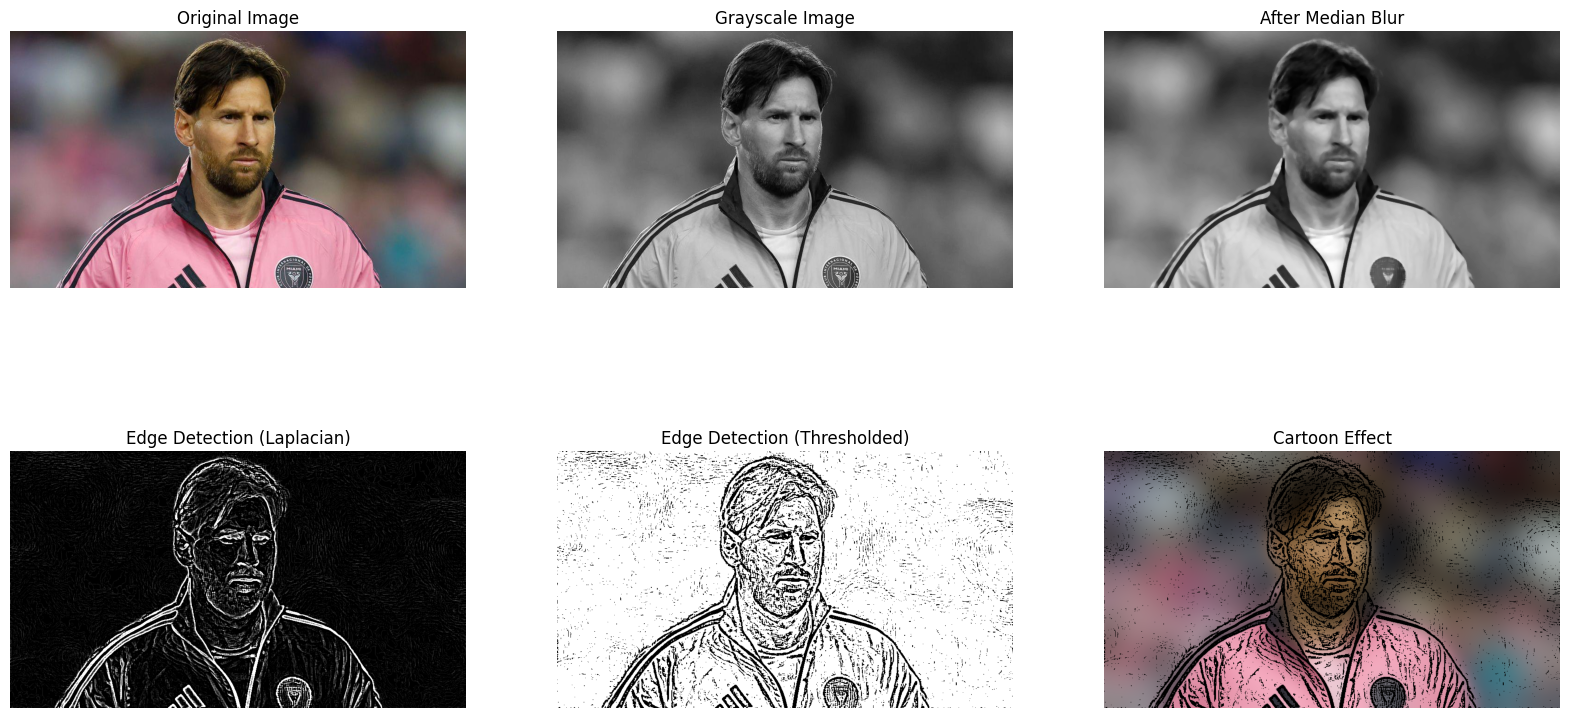

In [111]:
cartoonify_image("test images/Goat.jpg")
# detect_lanes("test2.png")